_Version log: Simulated Annealling._

In [5]:
import sys, time
import numpy as np
import CS_functions as cs
from tqdm import tqdm
from matplotlib import pyplot as plt
from scipy.constants import c as C

plt.rcParams.update({'font.size':18, 'lines.markersize': 6.0, 'lines.linewidth': 2.0, 'figure.facecolor': 'none', 'axes.facecolor': 'white'})
np.set_printoptions(threshold=sys.maxsize)

In [6]:
file_number = 27
file_name = "1dmockanderrors{:d}".format(file_number)
file_type = ".csv"

target, target_err = cs.open_dataset(file_name, ".csv")
optlocs_file = "data\\" + file_name +"_optlocs.csv"


In [7]:
reduced_points = 4
max_temp = 11
regularization_coeffient = 1e-3 # DECREASE FOR COMPLEX IMAGES (up to 1e-7 (floating point error?)) INCREASE FOR SIMPLE IMAGES (up to 1e-2)
min_seperation= 1
iterations= 5000
cooling= 0.999
subsampling_method= "random"

In [8]:
#########INITAILISATION##########

start_time = time.time()

temps = []
scores = np.array([])
total_points = target.shape[-1]
detectors = cs.subsample_1d(total_points, reduced_points, subsampling_method)
initialisation_detectors = np.copy(detectors)
score = new_score = cs.evaluate_score(detectors, target, target_err, regularization_coeffient= regularization_coeffient)
target_temp = max_temp
improvement = True

#######START SIMULATED ANNEALLING###########
for n in tqdm(range(iterations)):
    t = round(target_temp) #reset steps
    new_detectors = np.copy(detectors) #reset detectors
    new_score = np.copy(score) #reset score

    while t > 0:
        random_detector = np.random.randint(0, reduced_points) #random number between 0 and reduced_points. Includes 0. Excludes reduced_points
        current = new_detectors[random_detector]
        previous = -1 if random_detector == 0 else new_detectors[random_detector -1] #consider making the end points fixed. It helps define the length of the detector array.
        next = total_points if random_detector == reduced_points -1 else new_detectors[random_detector +1]
        if previous +min_seperation < current and current < next -min_seperation:
            #detector has space to move forward or back.
            new_detectors[random_detector] += np.random.choice([-1,1])
            t -= 1
        elif previous +min_seperation < current:
            #detector has space to move back.
            new_detectors[random_detector] -= 1
            t -= 1
        elif current < next -min_seperation:
            #detector has space to move forward.
            new_detectors[random_detector] += 1
            t -= 1
        else:
            #detector can't move.
            pass

    temps = temps + [[target_temp, np.linalg.norm(new_detectors -detectors, ord= 1)]] #L1 norm represents the number of times that the detectors were moved
    new_score = cs.evaluate_score(new_detectors, target, target_err, regularization_coeffient)

    if new_score < score:
        detectors = new_detectors
        score = new_score
        improvement = True
        best_iteration = n

    if target_temp <= 1: #When cold, stop optimising and start exploring new possiblities.
        target_temp = max_temp
        improvement = False
    elif improvement: #When hot, stop exploring and start optimising this regime.
        target_temp *= cooling

    scores = np.append(scores, score)

temps = np.array(temps).T

runtime = time.time() -start_time
print(f"Sim Annealing searched for {runtime} seconds and found a solution after {runtime *best_iteration/iterations} seconds")

c:\Users\rcr73298\Documents\THz-Compressed-Sensing\CS_functions.py:199: RuntimeWarning: divide by zero encountered in divide
  chi_square = np.linalg.norm((target -result) /uncertainty) #This is the chi-squared


  0%|          | 0/5000 [00:00<?, ?it/s]c:\Users\rcr73298\Documents\THz-Compressed-Sensing\CS_functions.py:199: RuntimeWarning: divide by zero encountered in divide
  chi_square = np.linalg.norm((target -result) /uncertainty) #This is the chi-squared
c:\Users\rcr73298\Documents\THz-Compressed-Sensing\CS_functions.py:199: RuntimeWarning: divide by zero encountered in divide
  chi_square = np.linalg.norm((target -result) /uncertainty) #This is the chi-squared
c:\Users\rcr73298\Documents\THz-Compressed-Sensing\CS_functions.py:199: RuntimeWarning: divide by zero encountered in divide
  chi_square = np.linalg.norm((target -result) /uncertainty) #This is the chi-squared
c:\Users\rcr73298\Documents\THz-Compressed-Sensing\CS_functions.py:199: RuntimeWarning: divide by zero encountered in divide
  chi_square = np.linalg.norm((target -result) /uncertainty) #This is the chi-squared
c:\Users\rcr73298\Documents\THz-Compressed-Sensing\CS_functions.py:199: RuntimeWarning: divide by zero encountered i

NameError: name 'best_iteration' is not defined

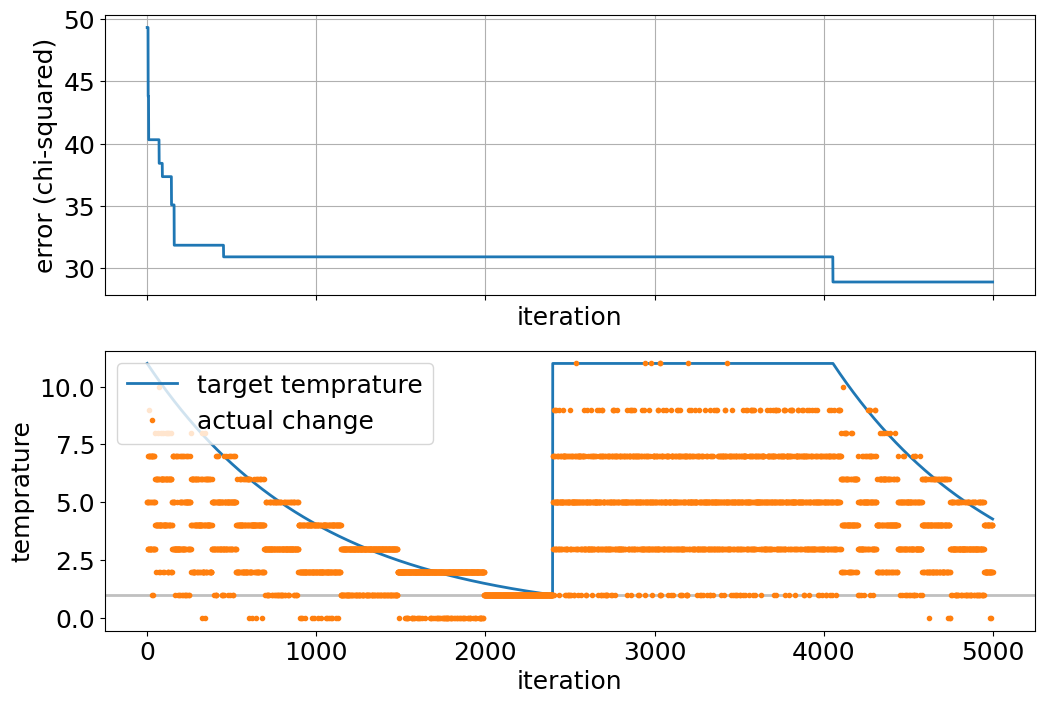

best score = 28.909


In [ ]:
fig, axs = plt.subplots(2,1, sharex= True, figsize= (12,8))

axs[0].plot(scores)
axs[0].grid(True)
axs[0].set(ylabel= "error (chi-squared)", xlabel= "iteration")

axs[1].hlines(1, 0, 1, color= "silver", transform=axs[1].get_yaxis_transform())
axs[1].plot(temps[0], label= "target temprature") #target temprature
axs[1].plot(temps[1], marker= ".", linestyle= "None", label= "actual change") #actual temprature due to bounds constraints.
axs[1].set(ylabel= "temprature", xlabel= "iteration")
axs[1].legend()

plt.show()

print("best score = {:.3f}".format(score))

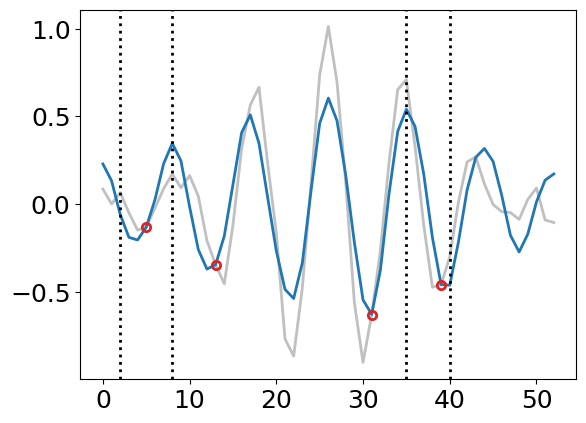

In [ ]:
samples = np.full_like(target, np.nan)
samples[detectors] = target[detectors]
result = cs.compressed_sensing(samples, regularization_coeffient)

plt.plot(target, color= "silver")
plt.plot(result)
plt.plot(samples, marker= "o", linestyle= "none", markeredgecolor= "tab:red", markerfacecolor= "none", markeredgewidth= 2)
plt.vlines(initialisation_detectors, ymin= 0, ymax= 1, linestyle= ":", color= "k", transform= plt.gca().get_xaxis_transform())
plt.show()

In [ ]:
cs.append_array_to_csv(detectors, optlocs_file)

print(*detectors, sep= ",")

5,13,31,39


## PROBIBLITY DISTROBUTION FOR WHERE THE SENSORS END UP AFTER SA OPTIMISATION

In [9]:
optlocs_file = r"data/1dmockanderrors27_randoptlocs.csv"
file_name = "1dmockanderrors27"
theta = 200 # arcminutes

sensor_distrobution = cs.open_csv(optlocs_file, number_of_columns= 8)
target, uncertainties = cs.open_dataset(file_name, file_type)
total_point = len(target)
displacement = np.arange(-26, 26 +1, 1) # 53 points, pixel pitch = 1 mm

In [10]:
frequent_locs = np.array(np.unique(sensor_distrobution, return_counts=True)).T
sensor_distrobution = np.ravel(sensor_distrobution[~np.isnan(sensor_distrobution)])
sensor_distrobution = sensor_distrobution *1 -26.0 #mm
#frequent_locs = frequent_locs[:-1] #remove nans
frequent_locs = frequent_locs[frequent_locs[:, 1].argsort()[::-1]]
#frequent_locs = [frequent_locs[frequent_locs[:,0].tolist().index(n),1] if n in frequent_locs[:,0] else np.nan for n in range(total_point)] # Put it back in order of sensor index.
#frequent_locs = np.array(frequent_locs)
print("Detector locations: Occurrences")
print(frequent_locs[:, :])

Detector locations: Occurrences
[[ 26 887]
 [ 27 339]
 [ 25 332]
 [ 22 332]
 [ 30 300]
 [  8 217]
 [ 44 212]
 [ 41 205]
 [ 11 205]
 [  9 202]
 [ 43 199]
 [ 45 193]
 [ 34 181]
 [ 17 177]
 [ 12 175]
 [ 10 174]
 [ 35 172]
 [ 40 170]
 [  7 163]
 [ 49 159]
 [ 18 156]
 [ 42 154]
 [  3 149]
 [  6 132]
 [ 50 131]
 [ 23 131]
 [ 21 127]
 [ 46 125]
 [ 31 124]
 [ 52 124]
 [  0 120]
 [ 29 117]
 [  2 114]
 [ 36 102]
 [ 15 100]
 [ 16  99]
 [ 39  97]
 [ 13  93]
 [ 38  89]
 [ 37  88]
 [ 14  83]
 [  5  77]
 [ 47  73]
 [  4  69]
 [ 48  67]
 [ 19  59]
 [ 51  53]
 [ 33  52]
 [  1  51]
 [ 32  45]
 [ 20  28]
 [ 24  11]
 [ 28   6]]


In [11]:
frequent_locs = [frequent_locs[frequent_locs[:,0].tolist().index(n),1] if n in frequent_locs[:,0] else 0 for n in range(total_point)] # Put it back in order of sensor index.
frequent_locs = np.array(frequent_locs)

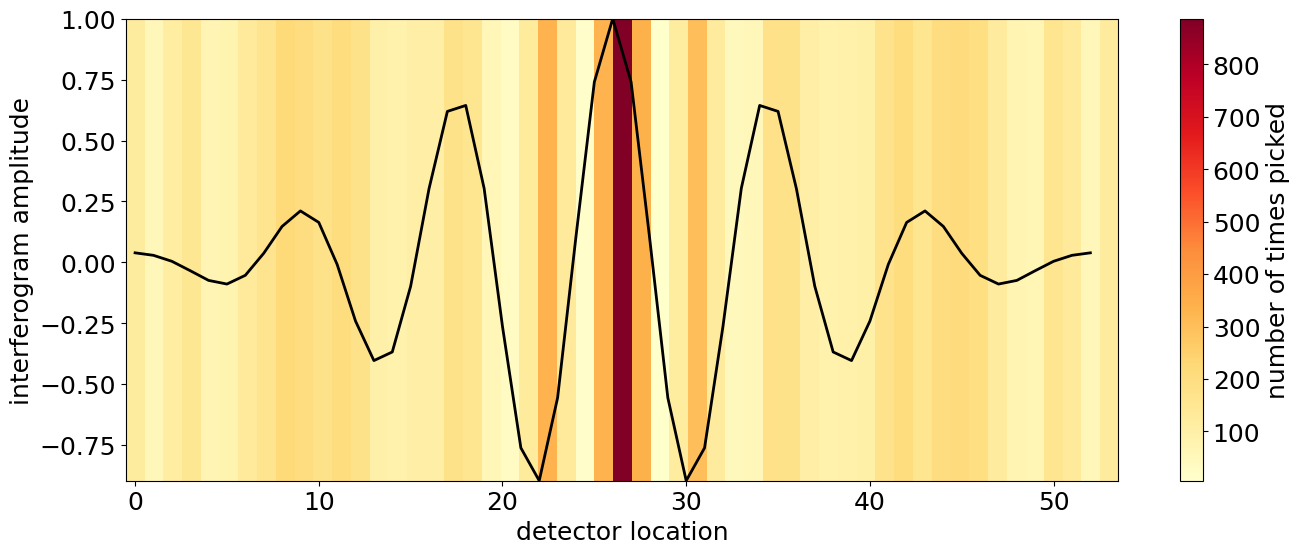

In [12]:
fig, axs = plt.subplots(figsize= (16,6))

axs.plot(target, color= "k", linewidth= 2, label= "interferogram")

im = plt.imshow([frequent_locs], aspect= "auto", extent= (-0.5, total_point +0.5, min(target), max(target)), cmap= "YlOrRd")#, norm= "log")
plt.colorbar(im, label= "number of times picked")

axs.set(xlabel= "detector location", ylabel= "interferogram amplitude")
plt.show()

In [13]:
sensor_distrobution

array([-17.,  -6.,  -1.,   0.,   4.,   9.,  10.,  23., -17.,   0.,   4.,
         5.,   9.,  16.,  21.,  22., -23., -13.,  -4.,   0.,   5.,   6.,
        15.,  24., -15.,  -9.,  -1.,   0.,   3.,  14.,  18.,  19., -20.,
       -19., -15., -14.,  -4.,   0.,   8.,  20., -26.,  -9.,  -8.,   0.,
         1.,   4.,  17.,  19., -19., -10.,  -4.,   0.,   1.,  12.,  14.,
        18., -20., -18., -15., -10.,  -8.,  -4.,  -1.,   0., -26., -14.,
       -11.,  -8.,   0.,   5.,  20.,  23., -16.,  -5.,  -1.,   0.,   3.,
         9.,  18.,  26., -26., -18., -13.,  -4.,   0.,   5.,  14.,  17.,
       -17., -13.,  -4.,   0.,   1.,  10.,  18.,  26., -16.,   0.,   1.,
         4.,  10.,  14.,  23.,  26., -18., -13.,  -1.,   0.,   3.,  11.,
        17.,  20., -23.,  -8.,  -4.,   9.,  10.,  16.,  23.,  24., -23.,
       -16.,  -5.,  -1.,   0.,   6.,   9.,  23.,  -9.,  -4.,  -1.,   0.,
         8.,  14.,  18.,  19., -14.,  -5.,   0.,   1.,   8.,  15.,  18.,
        26., -23., -15., -13., -10.,  -4.,  -1.,   

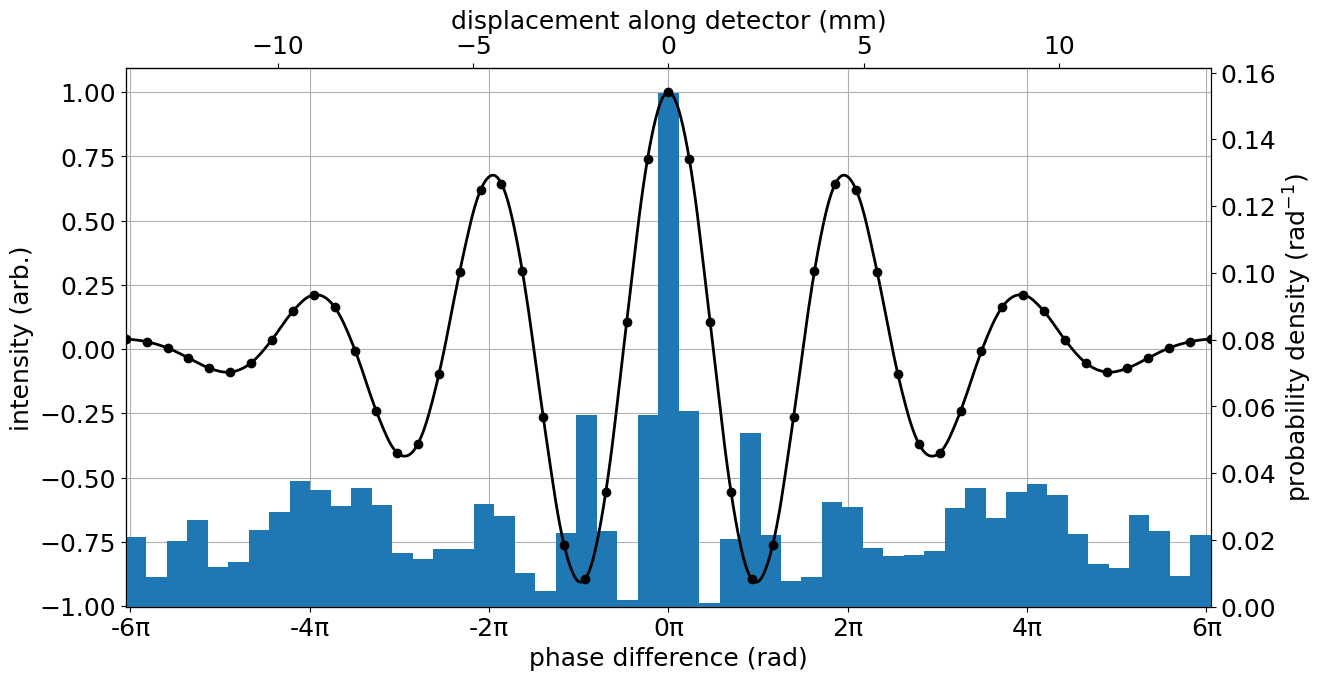

In [ ]:
bins = int(total_point//1)

def displacement2phase(displacement):
    return displacement*1e-3 * 2*np.sin(np.deg2rad(theta/60)) * 300e9/C * 2*np.pi
def phase2displacement(phase):
    return phase/(2*np.pi) / (2*np.sin(np.deg2rad(theta/60))) * C/300e9 * 1e3

phase_difference = displacement2phase(displacement)
sensor_phase = displacement2phase(sensor_distrobution)

### Create figure and axes (including secondary and twin axes)
fig, axs = plt.subplots(figsize= (14,7))
secax = axs.secondary_xaxis('top', functions=(displacement2phase, phase2displacement))
twinax = axs.twinx()
invisibleax = axs.twinx()

### Plot histogram on primary axes
axs.hist(sensor_phase, bins= bins, density= True, zorder= 3)
axs.set(ylabel= "probability density (rad$^{-1}$)", ylim= (0, None),
        xlabel= "phase difference (rad)", xlim= (phase_difference[0], phase_difference[-1]), xticks= np.arange(-6*np.pi, 6*np.pi +np.pi, 2*np.pi), xticklabels= [f"{i/np.pi:.0f}π" for i in np.arange(-6*np.pi, 6*np.pi +np.pi, 2*np.pi)])
axs.yaxis.set_label_position("right"); axs.yaxis.tick_right()
axs.grid(visible= True, axis= "x")
axs.patch.set_visible(False)

### Put displacement on secondary x-axis
secax.set_xlabel("displacement along detector (mm)")

### Plot interferogram on twin y-axis
twinax.plot(phase_difference, target, color= "k", linewidth= 2, label= "interferogram", linestyle= "none", marker= "o")
twinax.plot(cs.interpolate(phase_difference), cs.interpolate(target), color= "k")
twinax.set(ylabel= "intensity (arb.)")
twinax.yaxis.set_label_position("left"); twinax.yaxis.tick_left()

### Plot invisible twin y-axis to make the grid appear behind the histogram
invisibleax.set_zorder(-1)
invisibleax.set_ylim(twinax.get_ylim())
invisibleax.set_xticks(ticks= np.arange(-6*np.pi, 6*np.pi +np.pi, 2*np.pi))
invisibleax.tick_params(right=False, labelright=False, bottom= False, labelbottom=False)
invisibleax.spines['right'].set_visible(False)
invisibleax.grid(True)

plt.show()

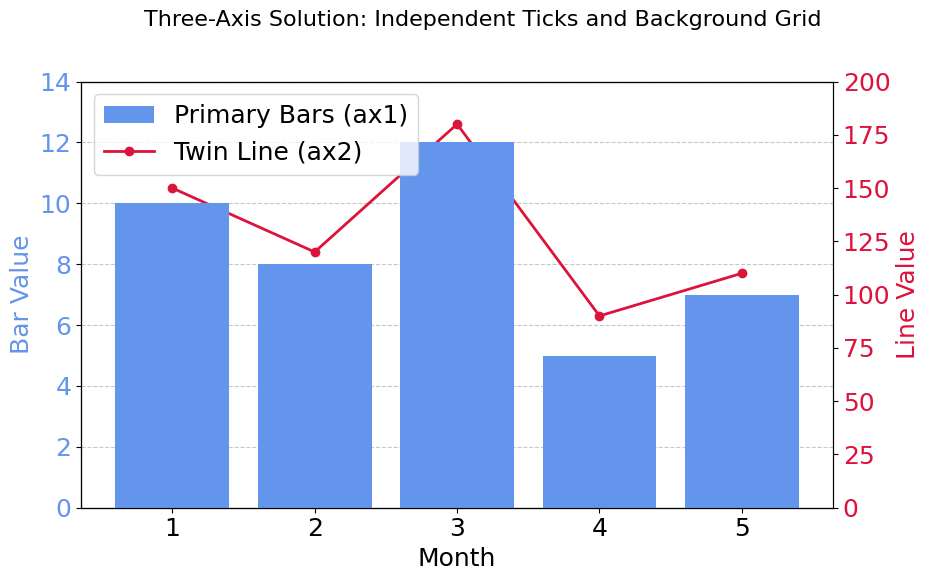

In [69]:
import matplotlib.pyplot as plt
import numpy as np

# Sample Data
x = np.arange(1, 6)
y1_bars = np.array([10, 8, 12, 5, 7])
y2_line = np.array([150, 120, 180, 90, 110])

# --- Plotting Setup ---
fig, ax1 = plt.subplots(figsize=(10, 6))

# --- CREATE ALL THREE AXES ---
# Create the twin axis for the line plot
ax2 = ax1.twinx()
# Create the third axis for the background grid
ax3 = ax1.twinx()

# --- CONFIGURE LAYER 1: The Primary Axis (ax1, on top) ---
ax1.bar(x, y1_bars, color='cornflowerblue', label='Primary Bars (ax1)')
ax1.set_xlabel('Month')
ax1.set_ylabel('Bar Value', color='cornflowerblue')
ax1.tick_params(axis='y', labelcolor='cornflowerblue')
ax1.set_ylim(0, 14)
# Set z-order to be on top and make background transparent
ax1.set_zorder(3)
ax1.patch.set_visible(False)
ax1.grid(False) # Ensure ax1 does not draw its own grid

# --- CONFIGURE LAYER 2: The Twin Axis (ax2, in the middle) ---
ax2.plot(x, y2_line, color='crimson', marker='o', label='Twin Line (ax2)')
ax2.set_ylabel('Line Value', color='crimson')
ax2.tick_params(axis='y', labelcolor='crimson')
ax2.set_ylim(0, 200)
# Set z-order and make background transparent
ax2.set_zorder(2)
ax2.patch.set_visible(False)
ax2.grid(False) # Ensure ax2 does not draw its own grid

# --- CONFIGURE LAYER 3: The Grid Axis (ax3, at the back) ---
# Move the spine to the right to avoid overlapping with ax2's spine
ax3.spines['right'].set_position(('axes', 1.15))
# Sync the y-limits with ax1 so the grid lines align perfectly
ax3.set_ylim(ax1.get_ylim())
# Make the axis itself invisible (no ticks, no labels, no spine)
ax3.tick_params(axis='y', right=False, labelright=False)
ax3.spines['right'].set_visible(False)
# Set z-order to be at the back
ax3.set_zorder(1)
# Draw the grid! This grid is now at the very back of the plot.
ax3.grid(True, linestyle='--', alpha=0.7, axis='y')


# --- FINAL TOUCHES: Unified Legend ---
# The legend should be on the topmost axis (ax1) to be visible
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc='upper left')

fig.suptitle('Three-Axis Solution: Independent Ticks and Background Grid', fontsize=16)
fig.tight_layout()
# Adjust layout to make room for the ax2 ylabel
fig.subplots_adjust(right=0.85)

plt.show()